In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from networkx.readwrite import json_graph

import os, json

# positive graph
with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

GP: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(GP)

# negative graph
with open("data/cisplatin_neg45k_kg.json") as f:
    data = json.load(f)

GN: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(GN)

MultiDiGraph with 6172 nodes and 848782 edges
MultiDiGraph with 7141 nodes and 4197345 edges


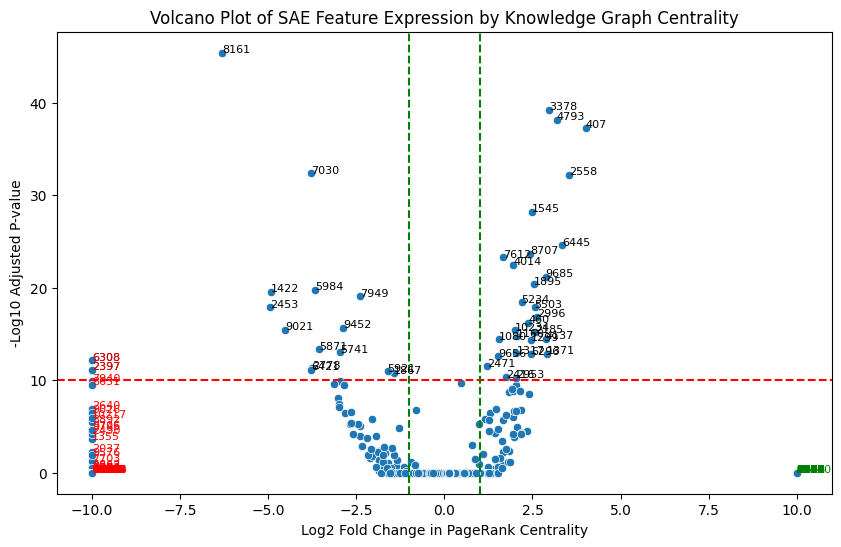

In [ ]:
# calculate PR centrality
pos_cent_nodes = nx.pagerank(GP)
neg_cent_nodes = nx.pagerank(GN)

# calculate difference in centrality
cent_diff = {x: 0 for x in set(GP.nodes()).union(set(GN.nodes()))}
for node in cent_diff.keys():
    pos_value = pos_cent_nodes.get(node, 0)
    neg_value = neg_cent_nodes.get(node, 0)

    # calculate log2 fold change
    if neg_value == 0:
        cent_diff[node] = 10
    elif pos_value/neg_value == 0:
        cent_diff[node] = -10
    else:
        cent_diff[node] = np.log2(pos_value / neg_value)
    # calculate pairwise t-test p-value (some degree of variance is assumed)
    p = stats.ttest_ind_from_stats(mean1=pos_value, std1=0.0001, nobs1=10,
                                   mean2=neg_value, std2=0.0001, nobs2=10,
                                   equal_var=False).pvalue
    cent_diff[node] = (cent_diff[node], p)

# apply bonferroni correction
num_tests = len(cent_diff) * 10 # account for small variance assumption in p-value calculation
for node in cent_diff.keys():
    log2fc, p = cent_diff[node]
    adj_p = min(p * num_tests, 1.0)
    cent_diff[node] = (log2fc, adj_p)


# use seaborn to make a volcano plot of the centrality differences
log2fc_values = [v[0] for v in cent_diff.values()]
p_values = [v[1] for v in cent_diff.values()]
neg_log10_p_values = [-np.log10(p) if p > 0 else 0 for p in p_values]

adj_p_threshold = 1e-10
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log2fc_values, y=neg_log10_p_values)
plt.title("Volcano Plot of SAE Feature Expression by Knowledge Graph Centrality")
plt.xlabel("Log2 Fold Change in PageRank Centrality")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(y=-np.log10(adj_p_threshold), color='r', linestyle='--')
plt.axvline(x=1, color='g', linestyle='--')
plt.axvline(x=-1, color='g', linestyle='--')
# add labels for significant points and outliers
for node, (log2fc, adj_p) in cent_diff.items():
    if adj_p < adj_p_threshold and abs(log2fc) > 1:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8)
    # highlight unique features
    if log2fc == 10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='green')
    elif log2fc == -10:
        plt.text(log2fc, -np.log10(adj_p), node, fontsize=8, color='red')
plt.show()